# Regresion Basica: Predecir eficiencia un vuelo aéreo

Para esta actividad de Regresión se busca un dataset en la página https://www.openml.org/d/1169 que trata de una Aerolinea de los estados de Estados Unidos. 

El desarrollo de esta actividad, voy a implementar dos algoritmos de regresión uno basado en redes neuronales y basado en regresión simple. Al finalizar, tendremos los dos modelos a comparar y se indicará cual se ajusta mejor al análisis.

En un problema de *regresion*, buscamos predecir la salida de un valor continuo como la probabilidad de un precio.

Para el desarrollo de este ejercicio, se ha tomando un dataset de vuelvos durante el mes de enero del 2021 entre los estados de Los Estados Unidos de Norte America, y se construye un modelo para predecir la eficiencia de los vuelos en cuanto a si hay o no retrasos. 
Para realizar lo anteriormente mencionado, se incluye atributos como: llenada tarde, día de la semana, aeropuerto de origen, aeropuerto de destino, aterrizaje con retrazo, y tiempo de vuelo 

In [37]:
#Librerias que se emplean para el desarrollo de los modelos

#Preparar y analizar los datos
import numpy as np
#Pandas porque me permite manipular y analizar los datos
import pandas as pd
#Permite crear gráficas
import matplotlib.pyplot as plt
#Seaborn para que me permita lavisualización de datos, es basada en matplotlib
import seaborn as sns 


#Librerias empleadas para redes Neuronales
#Tensorflow facilita la creación modelos de aprendizaje automático
import tensorflow as tf
#Keras es una API que ayuda a crear las redes neuronales 
from tensorflow import keras
#Layers permite generar las capas que se empleará para la red neuronal
from tensorflow.keras import layers


#Librerias empleadas para Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error

print(tf.__version__)

2.3.1


## El set de Datos del retraso de vuelo

### Obtenga la data
Primero que se debe hacer es obtener el set de datos, la solicitud es que se deba de leer por si solo, entonces he creado un repositorio en Github que me permita tener almacenada allí la información

In [38]:
#Se llama ese archivo mediante el uso de keras desde la dirección del repositorio, lo que hace Keras es crear un 
#guardado automático en tu equipo para estar trabajando
dataset_path = keras.utils.get_file("data_air", "https://raw.githubusercontent.com/ximenagongora/unir/master/REPORTING.csv")
dataset_path


'/Users/ximenagongora/.keras/datasets/data_air'

Seleccionamos las columnas a analizar. La hipótesis que voy a resolver, es predecir cual es el vuelo con más retrasos de acuerdo a su tiempo de llegada al sitio de destino.

In [39]:
column_names = ['ARR_DELAY_NEW','DAY_OF_WEEK','ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 'DEP_DELAY_NEW', 'AIR_TIME', 'DISTANCE']
# 'ORIGIN_CITY_NAME',
raw_dataset = pd.read_csv(dataset_path, delimiter=";") 

dataset = raw_dataset.copy()
dataset = dataset[column_names]
dataset.columns = ["ARR_DELAY",'DAY_OF_WEEK','ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID', 'DEP_DELAY_NEW', 'AIR_TIME', 'DISTANCE']

#El dataaset está compuesto por 15.999 registros con 7 columnas
dataset


,ARR_DELAY,DAY_OF_WEEK,ORIGIN_AIRPORT_SEQ_ID,DEST_AIRPORT_SEQ_ID,DEP_DELAY_NEW,AIR_TIME,DISTANCE
0,68.0,3,1389101,1477104,41.0,74.0,363
1,0.0,3,1389101,1477104,0.0,71.0,363
2,0.0,3,1389101,1483106,0.0,57.0,333
3,10.0,3,1389101,1483106,10.0,63.0,333
4,0.0,3,1389101,1483106,1.0,57.0,333
...,...,...,...,...,...,...,...
1594,43.0,4,1410005,1320402,47.0,131.0,861
1595,0.0,4,1410005,1320402,0.0,127.0,861
1596,0.0,4,1410005,1323202,0.0,101.0,668
1597,0.0,4,1410005,1323202,4.0,101.0,668


/Users/ximenagongora/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/ximenagongora/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


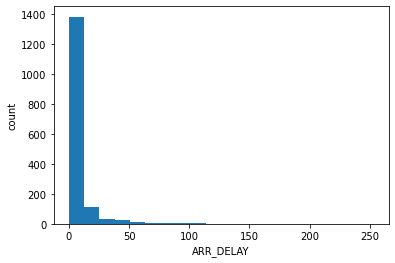

In [40]:
#Se obtiene un histograma para ver en valores absolutos los tiempos de retraso de los vuelos
plt.hist(dataset['ARR_DELAY'],bins = 20)
plt.xlabel("ARR_DELAY")
_=plt.ylabel("count")

In [41]:
#Se obtiene los cuartiles para agrupar los retrazos en un 25% y un 75% y verificar como se encuentran agrupados estos datos entre sí
Q1 = dataset['ARR_DELAY'].quantile(0.25)
Q3 = dataset['ARR_DELAY'].quantile(0.75)
IQR = Q3 - Q1
print (IQR)
df_out = dataset[-((dataset['ARR_DELAY'] < (Q1 - 1.5 * IQR)) | (dataset['ARR_DELAY']> Q3 + 1.5 * IQR))]
print(df_out.info())
print(df_out.describe())

2.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 1 to 1598
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ARR_DELAY              1276 non-null   float64
 1   DAY_OF_WEEK            1283 non-null   int64  
 2   ORIGIN_AIRPORT_SEQ_ID  1283 non-null   int64  
 3   DEST_AIRPORT_SEQ_ID    1283 non-null   int64  
 4   DEP_DELAY_NEW          1277 non-null   float64
 5   AIR_TIME               1276 non-null   float64
 6   DISTANCE               1283 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 80.2 KB
None
        ARR_DELAY  DAY_OF_WEEK  ORIGIN_AIRPORT_SEQ_ID  DEST_AIRPORT_SEQ_ID  \
count  1276.00000  1283.000000           1.283000e+03         1.283000e+03   
mean      0.29232     3.177708           1.393668e+06         1.293055e+06   
std       0.96770     0.688371           1.406078e+05         1.514811e+05   
min       0.00000     1.000000           1.014005e+06 

In [42]:
#se obtiene la información general del dataset, los tipos de datos, si hay campos nulos, 
#la cantidad de registro por variable, la cantidad de memoria usada
print(df_out.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 1 to 1598
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ARR_DELAY              1276 non-null   float64
 1   DAY_OF_WEEK            1283 non-null   int64  
 2   ORIGIN_AIRPORT_SEQ_ID  1283 non-null   int64  
 3   DEST_AIRPORT_SEQ_ID    1283 non-null   int64  
 4   DEP_DELAY_NEW          1277 non-null   float64
 5   AIR_TIME               1276 non-null   float64
 6   DISTANCE               1283 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 80.2 KB
None


<AxesSubplot:xlabel='ARR_DELAY'>

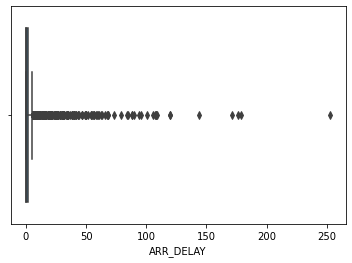

In [43]:
#El boxplot es un tipo de gráfico que nos permite identificar valores atípicos y comparar distribuciones. Aqui se evidencia que
#se tienen muchos valores atípicos
sns.boxplot(x= dataset['ARR_DELAY'])

In [44]:
#Agrupo el campo arrivo retrasado por tamaño para comprobar cuantos datos hay dentro de ella
print (dataset.groupby('ARR_DELAY').size())

ARR_DELAY
0.0      1145
1.0        29
2.0        27
3.0        28
4.0        29
         ... 
144.0       1
171.0       1
176.0       1
179.0       1
253.0       1
Length: 80, dtype: int64


### Limpie la data

Consulto cuando valores nulos o desconocidos hay en cada columna

In [45]:
dataset.isna().sum()

ARR_DELAY                7
DAY_OF_WEEK              0
ORIGIN_AIRPORT_SEQ_ID    0
DEST_AIRPORT_SEQ_ID      0
DEP_DELAY_NEW            6
AIR_TIME                 7
DISTANCE                 0
dtype: int64

In [46]:
#Elimino los datos nulos para poder trabajar con el dataset
dataset = dataset.dropna()

In [47]:
#Compruebo que el procedimiento se haya realizada y haya aplicado cambios
dataset.isna().sum()

ARR_DELAY                0
DAY_OF_WEEK              0
ORIGIN_AIRPORT_SEQ_ID    0
DEST_AIRPORT_SEQ_ID      0
DEP_DELAY_NEW            0
AIR_TIME                 0
DISTANCE                 0
dtype: int64

In [48]:
dataset.tail()

,ARR_DELAY,DAY_OF_WEEK,ORIGIN_AIRPORT_SEQ_ID,DEST_AIRPORT_SEQ_ID,DEP_DELAY_NEW,AIR_TIME,DISTANCE
1594,43.0,4,1410005,1320402,47.0,131.0,861
1595,0.0,4,1410005,1320402,0.0,127.0,861
1596,0.0,4,1410005,1323202,0.0,101.0,668
1597,0.0,4,1410005,1323202,4.0,101.0,668
1598,0.0,4,1410005,1323202,0.0,102.0,668


### Dividamos la data en entrenamiento y prueba

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas.

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

In [49]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspeccionar la data

Revise rapidamente la distribucion conjunta de un par de columnas de el set de entrenamiento.

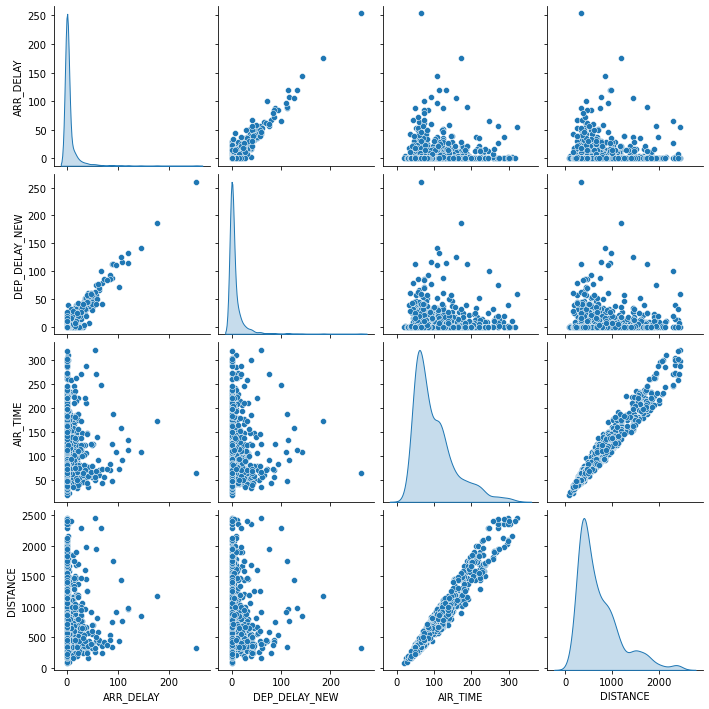

In [50]:
sns.pairplot(train_dataset[["ARR_DELAY",'DEP_DELAY_NEW', 'AIR_TIME', 'DISTANCE']], diag_kind="kde")

Generar estadisticas generales de los campos del dataset, excepto la variable de estudio

In [51]:
train_stats = train_dataset.describe()
train_stats.pop("ARR_DELAY")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
DAY_OF_WEEK,1274.0,3.171115e+00,0.686932,1.0,3.0,3.0,4.0,4.0
ORIGIN_AIRPORT_SEQ_ID,1274.0,1.391968e+06,143095.620838,1014005.0,1383002.0,1425005.5,1483106.0,1537604.0
DEST_AIRPORT_SEQ_ID,1274.0,1.298563e+06,150376.840509,1014005.0,1129202.0,1320402.0,1410702.0,1537604.0
DEP_DELAY_NEW,1274.0,6.994505e+00,17.876045,0.0,0.0,0.0,6.0,261.0
AIR_TIME,1274.0,1.003556e+02,54.893111,20.0,59.0,83.0,123.0,321.0
DISTANCE,1274.0,7.165447e+02,460.526820,84.0,371.0,575.5,920.0,2462.0


### Separar las caracteristicas de las etiquetas.

Separe la columna a estudiar. Esta etiqueta es el valor que entrenara el modelo para predecir.

In [52]:
train_labels = train_dataset.pop('ARR_DELAY')
test_labels = test_dataset.pop('ARR_DELAY')

In [53]:
#Se hace una consulta de la nueva variable a estudiar
test_labels.describe()

count    318.000000
mean       6.084906
std       19.981909
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max      179.000000
Name: ARR_DELAY, dtype: float64

### Normalice la data

La normalización de los datos se realiza para evitar cualquier tipo de anomalía, redundancia ó sesgo de la información. 

Es una buena práctica normalizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría  converger sin normalización de características, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [54]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [55]:
train_dataset.keys()

Index(['DAY_OF_WEEK', 'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID',
       'DEP_DELAY_NEW', 'AIR_TIME', 'DISTANCE'],
      dtype='object')

Estos datos normalizados es lo que usaremos para entrenar el modelo.

Precaución: las estadísticas utilizadas para normalizar las entradas aquí (media y desviación estándar) deben aplicarse a cualquier otro dato que se alimente al modelo, junto con la codificación de un punto que hicimos anteriormente. Eso incluye el conjunto de pruebas, así como los datos en vivo cuando el modelo se usa en producción.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. Los pasos de construcción del modelo se envuelven en una función, `build_model`, ya que crearemos un segundo modelo, más adelante.

In [56]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [57]:
model = build_model()

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


Ahora se prueba el modelo, para ello tomé 15 ejemplos de los datos de entrenamiento.

In [60]:
example_batch = normed_train_data [:15] 
example_result = model.predict(example_batch)
example_result                            

array([[-0.04467235],
       [ 0.2598368 ],
       [-0.00857797],
       [ 0.22627003],
       [-0.06465748],
       [-0.08137475],
       [ 0.02896066],
       [-0.22916518],
       [ 0.20106854],
       [-0.09914072],
       [-0.13175008],
       [-0.06745291],
       [-0.08999554],
       [ 0.2109651 ],
       [ 0.04529028]], dtype=float32)

Parece estar funcionando, y produce un resultado de la forma y tipo esperados.

### Entrenar a la modelo

Entrene el modelo durante 50 épocas y registre la precisión de entrenamiento y validación en el objeto `history`.

In [61]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 50 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


..................................................
..................................................

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [62]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,21.417341,2.538038,21.417341,24.579264,2.748524,24.579264,95
96,21.580816,2.543373,21.580816,25.412613,2.825557,25.412613,96
97,21.310993,2.517915,21.310993,25.340601,2.789922,25.340599,97
98,21.480211,2.513540,21.480211,24.607212,2.722498,24.607212,98
99,21.630196,2.512928,21.630196,24.739328,2.757784,24.739328,99


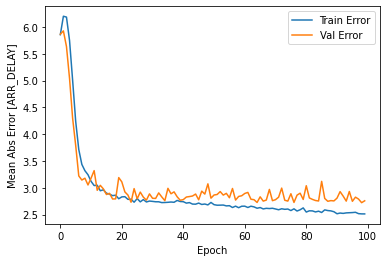

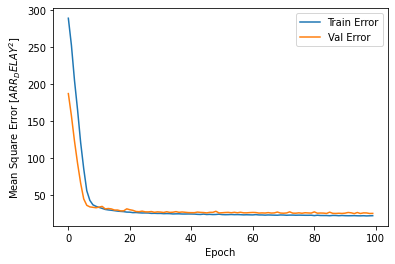

In [63]:
#Se grafica el comportamiento del error medio abasoluto de la varibale arrivo tarde en datos de entrenamiento y validación

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ARR_DELAY]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ARR_DELAY^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Se realiza una validación de la gráfica, haciendose un early stop, para cuando ya no exista relación entre las variables, se detenga la ejecución


..................................................
................................................

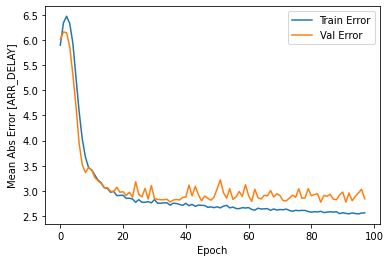

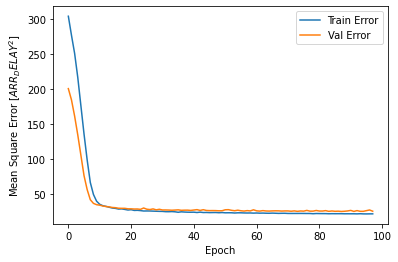

In [64]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

Se sacan los valores d elas pédidas, media, mediana, el error medio absoluto

In [65]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} ARR_DELAY".format(mae))

10/10 - 0s - loss: 23.3678 - mae: 2.6838 - mse: 23.3678
Testing set Mean Abs Error:  2.68 ARR_DELAY


### Haga Predicciones

Finalmente, prediga los valores de arrivo tarde utilizando datos en el conjunto de pruebas:

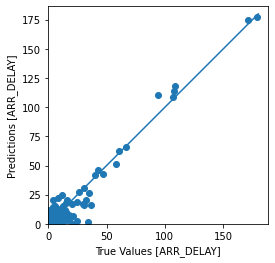

In [66]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [ARR_DELAY]')
plt.ylabel('Predictions [ARR_DELAY]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-180, 180], [-180, 180])


El modelo predice razonablemente bien.

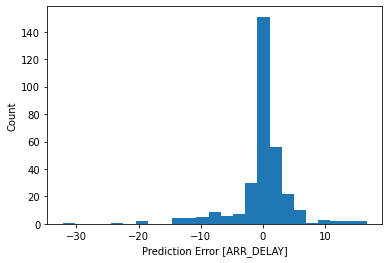

In [67]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [ARR_DELAY]")
_ = plt.ylabel("Count")

### ÁRBOL DE CLASIFICACIÓN RANDOM FOREST REGRESSOR


In [32]:
# Grid de hiperparámetros evaluados

param_grid = ParameterGrid(
                {'n_estimators': [50],
                 'max_features': ['auto','log2'],
                 'max_depth'   : [None, 3, 10],
                 'criterion'   : ['mae']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros

resultados = {'params': [], 'oob_accuracy':[], 'modelo': []}

for params in param_grid:
    
    model = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    model.fit(normed_train_data, train_labels)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(model.oob_score)
    resultados['modelo'].append(model)
    print (F"Modelo: {params} \u2713")

#Resultados

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 50} ✓
Modelo: {'criterion': 'mae', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 50} ✓
Modelo: {'criterion': 'mae', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 50} ✓
Modelo: {'criterion': 'mae', 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 50} ✓
Modelo: {'criterion': 'mae', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 50} ✓
Modelo: {'criterion': 'mae', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50} ✓


,oob_accuracy,modelo,criterion,max_depth,max_features,n_estimators
0,True,"(DecisionTreeRegressor(criterion='mae', max_fe...",mae,NaN,auto,50
1,True,"(DecisionTreeRegressor(criterion='mae', max_fe...",mae,NaN,log2,50
2,True,"(DecisionTreeRegressor(criterion='mae', max_de...",mae,3.0,auto,50
3,True,"(DecisionTreeRegressor(criterion='mae', max_de...",mae,3.0,log2,50


In [34]:
# Entrenamiento del modelo final
modelorandom_final = resultados.iloc[0,1]

predicciones= modelorandom_final.predict(X = normed_test_data)

rmae = mean_absolute_error(
            y_true = test_labels,
            y_pred = predicciones
)
print(f"El error (mae) de prueba es: {rmae}")

El error (mae) de prueba es: 2.948396226415094


In [ ]:
#https://www.tensorflow.org/tutorials/keras/regression?hl=es-419